In [1]:
%matplotlib inline
import os,random

os.environ["KERAS_BACKEND"] = "tensorflow"
os.environ["KERAS_FLAGS"]  = "device=gpu%d"%(0)

import numpy as np
from keras.utils import np_utils
import keras.models as models
from keras.layers.core import Reshape,Dense,Dropout,Activation,Flatten
from keras.layers.noise import GaussianNoise
from keras.layers.convolutional import Conv2D, MaxPooling2D, ZeroPadding2D
from keras.regularizers import *
from keras.optimizers import adam
import matplotlib.pyplot as plt
import seaborn as sns
import cPickle, random, sys, keras
import missinglink

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"



Using TensorFlow backend.


In [2]:
# Load the dataset ...
#  You will need to seperately download or generate this file
Xd = cPickle.load(open("RML2016.10a_dict.dat",'rb'))
snrs,mods = map(lambda j: sorted(list(set(map(lambda x: x[j], Xd.keys())))), [1,0])
X = []  
lbl = []
for mod in mods:
    for snr in snrs:
        X.append(Xd[(mod,snr)])
        for i in range(Xd[(mod,snr)].shape[0]):  lbl.append((mod,snr))
X = np.vstack(X)

In [3]:
# Partition the data
#  into training and test sets of the form we can train/test on 
#  while keeping SNR and Mod labels handy for each
np.random.seed(2016)
n_examples = X.shape[0]
n_train = n_examples * 0.5
train_idx = np.random.choice(range(0,int(n_examples)), size=int(n_train), replace=False)
test_idx = list(set(range(0,n_examples))-set(train_idx))
X_train = X[train_idx]
X_test =  X[test_idx]
def to_onehot(yy):
    yy1 = np.zeros([len(yy), max(yy)+1])
    yy1[np.arange(len(yy)),yy] = 1
    return yy1
Y_train = to_onehot(map(lambda x: mods.index(lbl[x][0]), train_idx))
Y_test = to_onehot(map(lambda x: mods.index(lbl[x][0]), test_idx))

In [4]:
in_shp = list(X_train.shape[1:])
print X_train.shape, in_shp
classes = mods

(110000, 2, 128) [2, 128]


In [17]:

# Build VT-CNN2 Neural Net model using Keras primitives -- 
#  - Reshape [N,2,128] to [N,1,2,128] on input
#  - Pass through 2 2DConv/ReLu layers
#  - Pass through 2 Dense layers (ReLu and Softmax)
#  - Perform categorical cross entropy optimization

dr = 0.5 # dropout rate (%)
model = models.Sequential()
model.add(Reshape(in_shp+[1], input_shape=in_shp))
model.add(ZeroPadding2D((0,2)))
model.add(Conv2D(256,(1,3),kernel_initializer="glorot_uniform", name="conv1", activation="relu", padding="valid"))
model.add(Dropout(dr))
model.add(ZeroPadding2D((0, 2)))
model.add(Conv2D(80,(2,3),padding="valid", activation="relu", name="conv2", kernel_initializer='glorot_uniform'))
model.add(Dropout(dr))
model.add(Flatten())
model.add(Dense(256, kernel_initializer="he_normal", activation="relu", name="dense1"))
model.add(Dropout(dr))
model.add(Dense(11, kernel_initializer="he_normal", name="dense2"))
model.add(Activation('softmax'))
model.add(Reshape([len(classes)]))
model.compile(loss='categorical_crossentropy', optimizer='adam')
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape_13 (Reshape)         (None, 2, 128, 1)         0         
_________________________________________________________________
zero_padding2d_15 (ZeroPaddi (None, 2, 132, 1)         0         
_________________________________________________________________
conv1 (Conv2D)               (None, 2, 130, 256)       1024      
_________________________________________________________________
dropout_7 (Dropout)          (None, 2, 130, 256)       0         
_________________________________________________________________
zero_padding2d_16 (ZeroPaddi (None, 2, 134, 256)       0         
_________________________________________________________________
conv2 (Conv2D)               (None, 1, 132, 80)        122960    
_________________________________________________________________
dropout_8 (Dropout)          (None, 1, 132, 80)        0         
__________

In [18]:
# Set up some params 
nb_epoch = 100     # number of epochs to train on
batch_size = 1024  # training batch size

In [ ]:
# perform training ...
missinglink_callback = missinglink.KerasCallback(owner_id="73b7dbec-273d-c6b7-776d-55812449a4e4", project_token="WxqnIeHhwiLIFejy")
missinglink_callback.set_properties(display_name='Base experiment', description='Initial base mode for experiment')
#   - call the main training loop in keras for our network+dataset
filepath = 'convmodrecnets_CNN2_0.5.wts.h5'
history = model.fit(X_train,
    Y_train,
    batch_size=batch_size,
    nb_epoch=nb_epoch,
    verbose=2,
    validation_data=(X_test, Y_test),
    callbacks = [
        keras.callbacks.ModelCheckpoint(filepath, monitor='val_loss', verbose=0, save_best_only=True, mode='auto'),
        keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, verbose=0, mode='auto'),
        keras.callbacks.TensorBoard(log_dir='./logs', histogram_freq=0, write_graph=True, write_images=False)
    ])
# we re-load the best weights once training is finished
model.load_weights(filepath)

/home/yoni/repos/thesis/university/university/local/lib/python2.7/site-packages/keras/models.py:837: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  warnings.warn('The `nb_epoch` argument in `fit` '


Train on 110000 samples, validate on 110000 samples
Epoch 1/100


In [9]:
# Show simple version of performance
score = model.evaluate(X_test, Y_test, verbose=0, batch_size=batch_size)
print score

1.51117721852


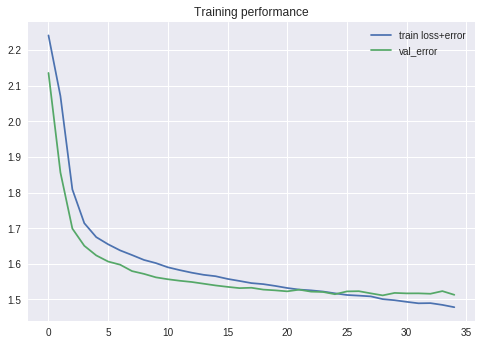

In [10]:
# Show loss curves 
plt.figure()
plt.title('Training performance')
plt.plot(history.epoch, history.history['loss'], label='train loss+error')
plt.plot(history.epoch, history.history['val_loss'], label='val_error')
plt.legend()

In [11]:
def plot_confusion_matrix(cm, title='Confusion matrix', cmap=plt.cm.Blues, labels=[]):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(labels))
    plt.xticks(tick_marks, labels, rotation=45)
    plt.yticks(tick_marks, labels)
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

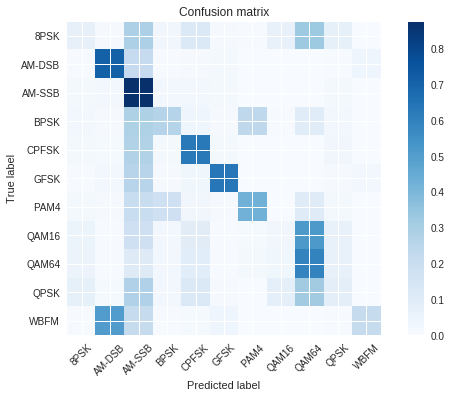

In [12]:
# Plot confusion matrix
test_Y_hat = model.predict(X_test, batch_size=batch_size)
conf = np.zeros([len(classes),len(classes)])
confnorm = np.zeros([len(classes),len(classes)])
for i in range(0,X_test.shape[0]):
    j = list(Y_test[i,:]).index(1)
    k = int(np.argmax(test_Y_hat[i,:]))
    conf[j,k] = conf[j,k] + 1
for i in range(0,len(classes)):
    confnorm[i,:] = conf[i,:] / np.sum(conf[i,:])
plot_confusion_matrix(confnorm, labels=classes)



Overall Accuracy:  0.0942360475755


Overall Accuracy:  0.0919164396004


Overall Accuracy:  0.0960564399421


Overall Accuracy:  0.102850956333


Overall Accuracy:  0.119416590702


Overall Accuracy:  0.170606006753


Overall Accuracy:  0.287892706228


Overall Accuracy:  0.475806451613


Overall Accuracy:  0.587245841035


Overall Accuracy:  0.623911465893


Overall Accuracy:  0.58704379562


Overall Accuracy:  0.555616139586


Overall Accuracy:  0.555983847283


Overall Accuracy:  0.551444043321


Overall Accuracy:  0.547159603246


Overall Accuracy:  0.552094717668


Overall Accuracy:  0.54752851711


Overall Accuracy:  0.548256135818


Overall Accuracy:  0.549140271493


Overall Accuracy:  0.562376237624


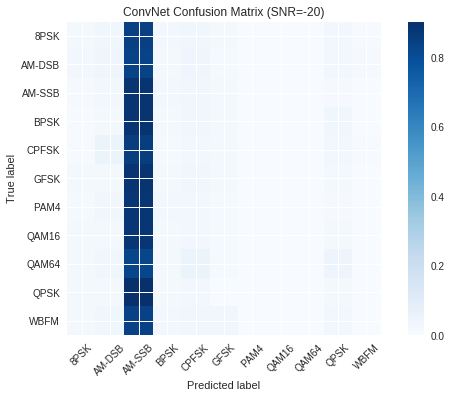

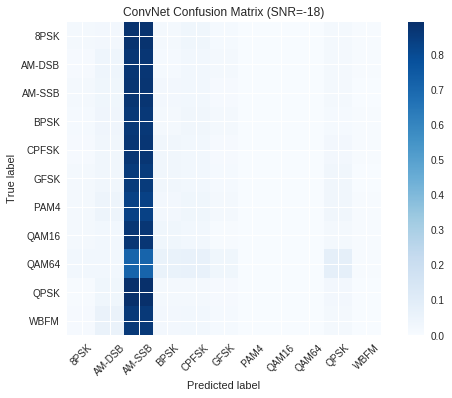

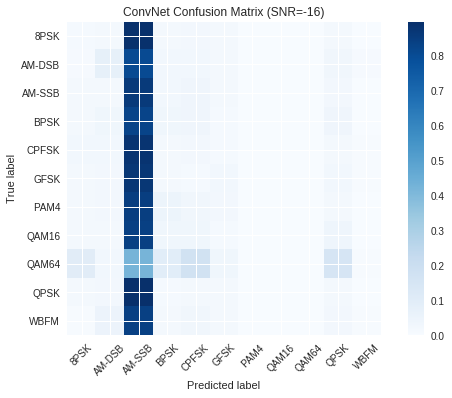

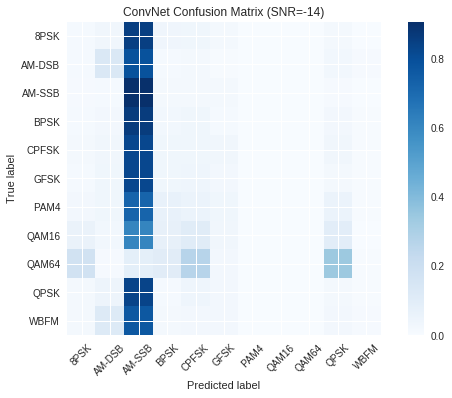

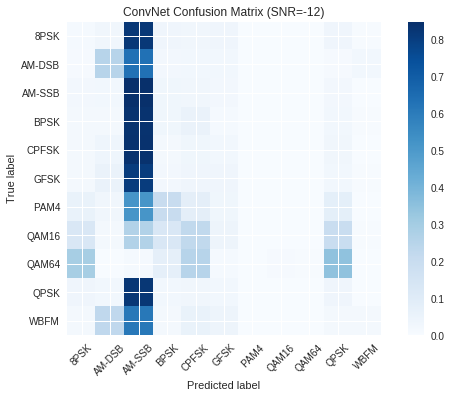

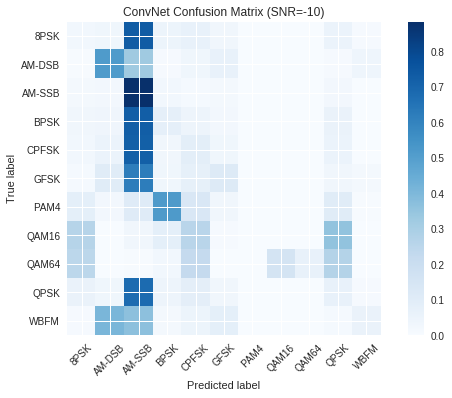

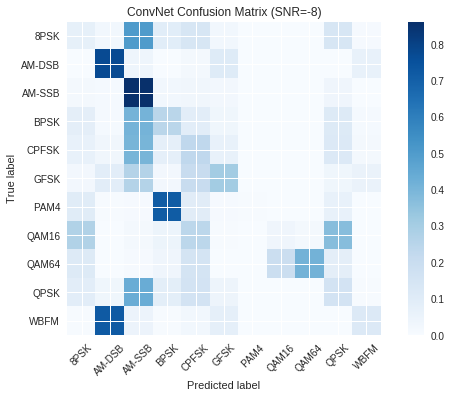

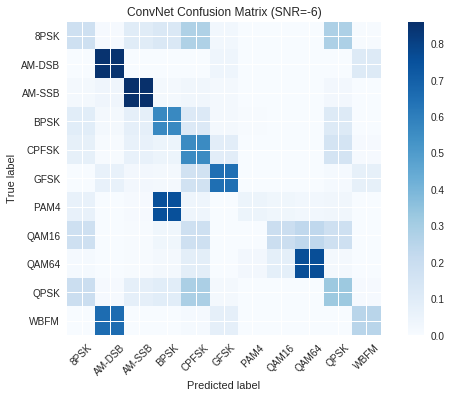

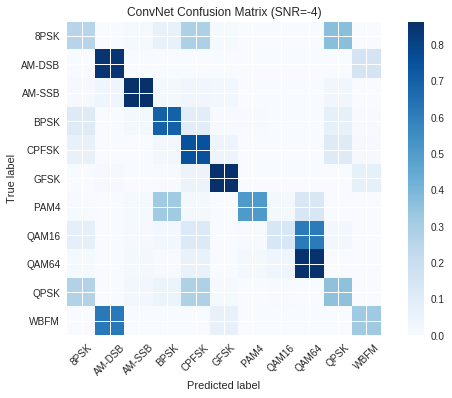

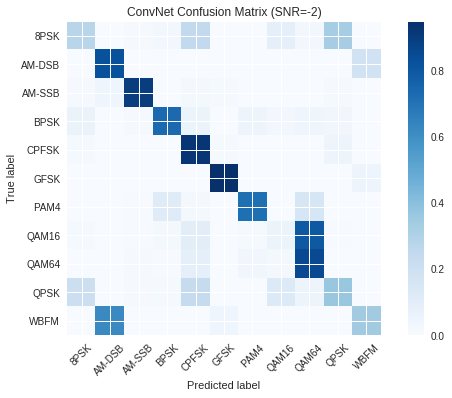

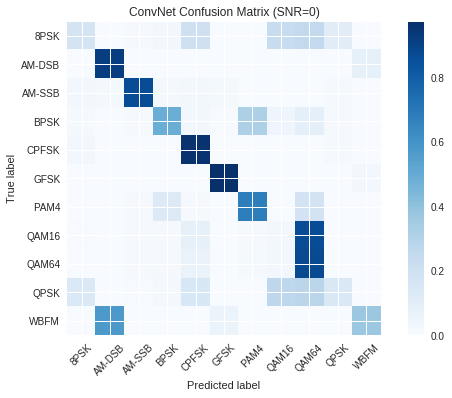

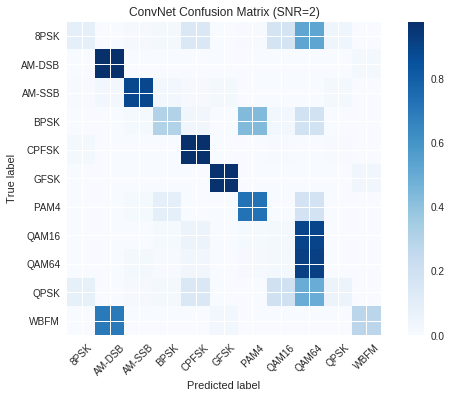

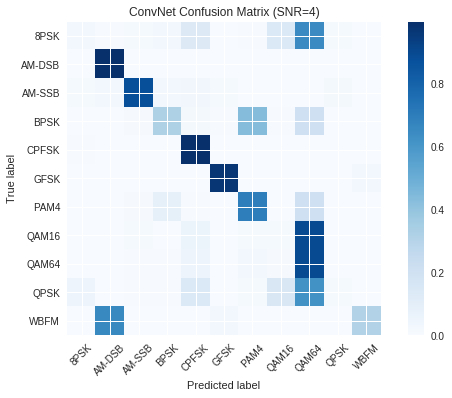

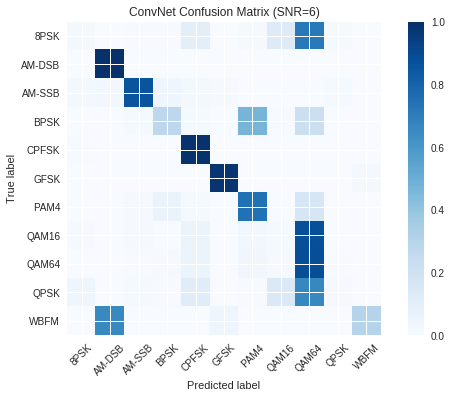

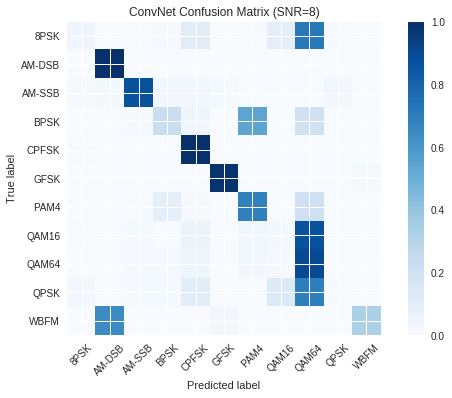

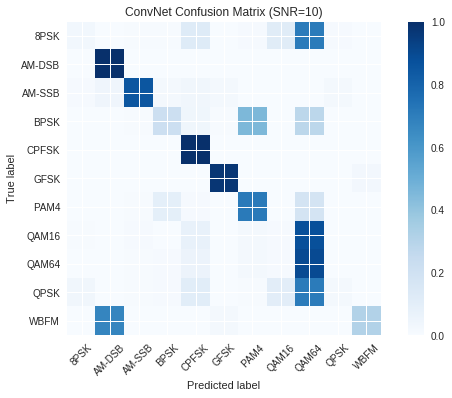

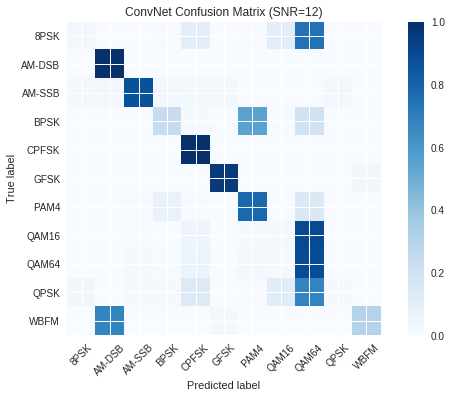

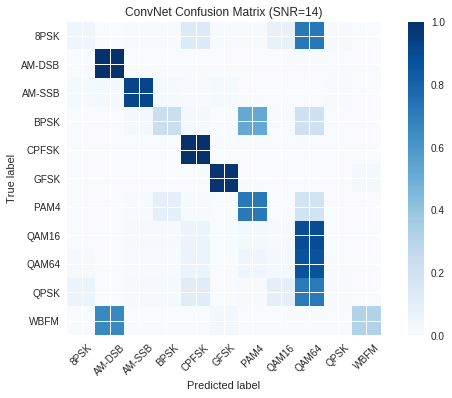

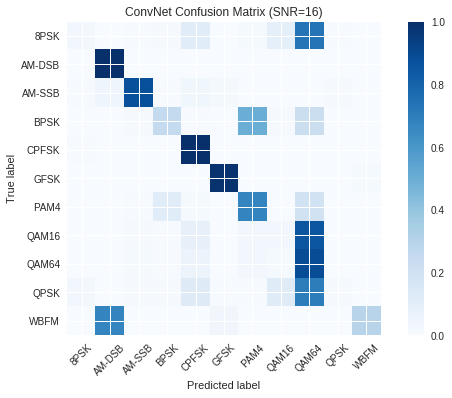

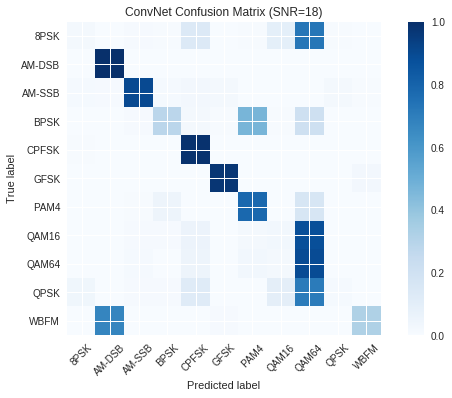

In [17]:
  
# Plot confusion matrix
acc = {}
for snr in snrs:
    # extract classes @ SNR
    test_SNRs = map(lambda x: lbl[x][1], test_idx)
    test_X_i = X_test[np.where(np.array(test_SNRs)==snr)]
    test_Y_i = Y_test[np.where(np.array(test_SNRs)==snr)]    
    # estimate classes
    test_Y_i_hat = model.predict(test_X_i)
    conf = np.zeros([len(classes),len(classes)])
    confnorm = np.zeros([len(classes),len(classes)])
    for i in range(0,test_X_i.shape[0]):
        j = list(test_Y_i[i,:]).index(1)
        k = int(np.argmax(test_Y_i_hat[i,:]))
        conf[j,k] = conf[j,k] + 1
    for i in range(0,len(classes)):
        confnorm[i,:] = conf[i,:] / np.sum(conf[i,:])
    plt.figure()
    plot_confusion_matrix(confnorm, labels=classes, title="ConvNet Confusion Matrix (SNR=%d)"%(snr))
    
    cor = np.sum(np.diag(conf))
    ncor = np.sum(conf) - cor
    print "Overall Accuracy: ", cor / (cor+ncor)
    acc[snr] = 1.0*cor/(cor+ncor)
    

In [18]:
# Save results to a pickle file for plotting later
print acc
fd = open('results_cnn2_d0.5.dat','wb')
cPickle.dump( ("CNN2", 0.5, acc) , fd )

{0: 0.58704379562043796, 16: 0.54914027149321265, 2: 0.55561613958560518, 4: 0.55598384728340677, 6: 0.55144404332129959, 8: 0.54715960324616775, 12: 0.54752851711026618, 10: 0.55209471766848817, -20: 0.094236047575480333, 18: 0.56237623762376243, -18: 0.091916439600363303, -16: 0.096056439942112881, -14: 0.10285095633345363, -12: 0.11941659070191431, 14: 0.5482561358184167, -10: 0.17060600675315443, -8: 0.28789270622818297, -6: 0.47580645161290325, -4: 0.58724584103512012, -2: 0.62391146589259794}


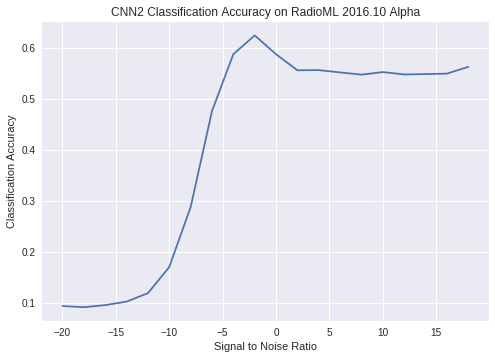

In [19]:
# Plot accuracy curve
plt.plot(snrs, map(lambda x: acc[x], snrs))
plt.xlabel("Signal to Noise Ratio")
plt.ylabel("Classification Accuracy")
plt.title("CNN2 Classification Accuracy on RadioML 2016.10 Alpha")